In [90]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [91]:
import numpy as np
import pandas as pd

In [92]:
import datetime as dt
from dateutil.relativedelta import relativedelta

# Reflect Tables into SQLAlchemy ORM

In [93]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, literal

In [94]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [95]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [96]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [97]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [98]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

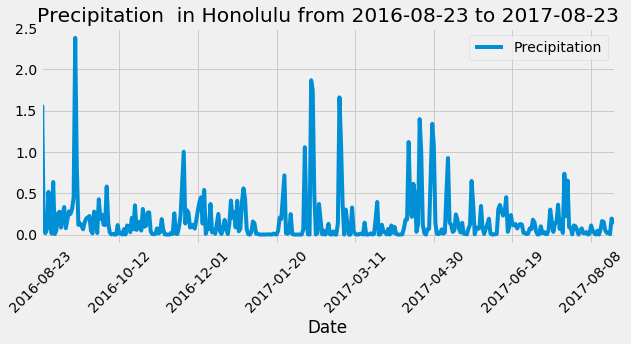

In [99]:
#[-] Design a query to retrieve the last 12 months of precipitation data and plot the results

#Do a quiery to get last date in the data base
#Since the instructions says vacations are in Honolulu, Hawaiiwe
#queries are related to thsi citiy only

sel = [Measurement.date, Measurement.prcp]
last_record = session.query(*sel).\
                    order_by(Measurement.date.desc()).first()

# Calculate the date 1 year ago from the last data point in the database
parser_list = last_record[0].split("-")
last_date = dt.datetime(int(parser_list[0]),int(parser_list[1]),int(parser_list[2]))
start_date = last_date + relativedelta(months=-12)
# Perform a query to retrieve the data and precipitation scores
results = session.query(*sel).\
                filter(Measurement.date >= start_date.strftime("%Y-%m-%d")).\
                    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
#The data is already sorted by the query
date = [entry[0] for entry in results]
prcp = [entry[1] for entry in results]

#Creating the data frame
place_prcp_df = pd.DataFrame({"Date":date,
                              "Precipitation":prcp})

#Droping non existing records
place_prcp_df.dropna(inplace=True)

#Since we have multiple days per statition we need to average
avg_per_day_df = place_prcp_df.groupby("Date").mean()

# Use Pandas Plotting with Matplotlib to plot the data
#Plot the reults
str_start_date = start_date.strftime("%Y-%m-%d")
str_end_date = last_date.strftime("%Y-%m-%d")
title=f"Precipitation  in Honolulu from {str_start_date} to {str_end_date}"
avg_per_day_df.plot(figsize=(9,5),title=title)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [100]:
# Use Pandas to calcualte the summary statistics for the precipitation data
place_prcp_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [101]:
# Design a query to show how many stations are available in this dataset?
sel = [Station.station]
stations = session.query(*sel).count()
stations

9

In [102]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_count = session.query(Measurement.station, func.count(Measurement.station)).\
                    group_by(Measurement.station).order_by(func.count(Measurement.station).\
                        desc()).all()
station_count

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [103]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

#Get the higest count station
most_active = session.query(Measurement.station, func.count(Measurement.station)).\
                    group_by(Measurement.station).order_by(func.count(Measurement.station).\
                        desc()).first()

qry = session.query(func.min(Measurement.tobs), 
                    func.max(Measurement.tobs),
                    func.avg(Measurement.tobs),
                    ).filter(Measurement.station == most_active[0]).all()
qry

[(54.0, 85.0, 71.66378066378067)]

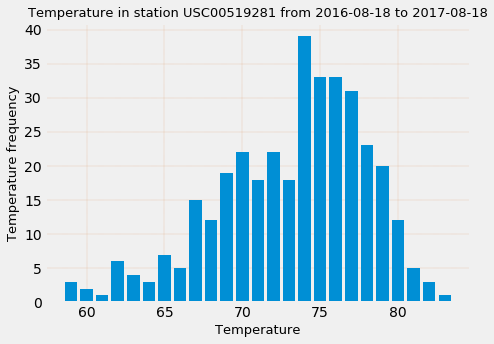

In [115]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station
#and plot the results as a histogram

sel = [Measurement.station, Measurement.date, Measurement.tobs]
last_ma_rec = session.query(*sel).filter(Measurement.station == Station.station).\
                filter(Measurement.station == most_active[0]).\
                    order_by(Measurement.date.desc()).first()

parser_list = last_ma_rec[1].split("-")
last_date = dt.datetime(int(parser_list[0]),int(parser_list[1]),int(parser_list[2]))
start_date = last_date + relativedelta(months=-12)
# Perform a query to retrieve the data and precipitation scores
results_ma = session.query(*sel).\
                filter(Measurement.station == most_active[0]).\
                    filter(Measurement.date >= start_date.strftime("%Y-%m-%d")).\
                        filter(Measurement.date <= last_date.strftime("%Y-%m-%d")).\
                            order_by(Measurement.date).all()

#The data is already sorted by the query
date = [entry[1] for entry in results_ma]
temp = [entry[2] for entry in results_ma]

#Creating the data frame
temp_ocur_df = pd.DataFrame({"Date":date,"Temp":temp})

#Droping non existing records
temp_ocur_df.dropna(inplace=True)

#Counting the number of time a temperature is repeated 
temp_count = temp_ocur_df.groupby("Temp").count()
#temp_count

#Plot the reults
temp_plot = plt.figure(figsize=(7,5))
#temp_plot = plt.figure()
plt.bar(temp_count.index.values,\
        temp_count["Date"],
        )

str_start_date = start_date.strftime("%Y-%m-%d")
str_end_date = last_date.strftime("%Y-%m-%d")

plt.title(f"Temperature in station {most_active[0]} from {str_start_date} to {str_end_date}",fontsize=13)
#plt.title("test")
plt.xlabel("Temperature",fontsize=13)
plt.ylabel("Temperature frequency",fontsize=13)
plt.grid(color="#DC7633",linewidth=0.2,linestyle='--')
plt.tight_layout()
plt.show()

In [116]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """
    TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [125]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
max_val_date = calc_temps(start_date.strftime("%Y-%m-%d"), last_date.strftime("%Y-%m-%d"))[0]

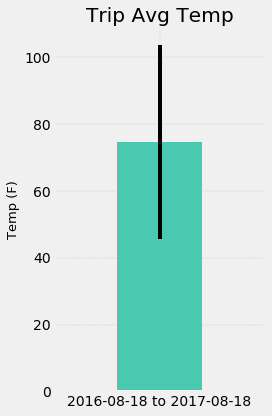

In [126]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
title_plot = plt.figure(figsize=(4,6))
plt.bar([start_date.strftime("%Y-%m-%d")+" to "+last_date.strftime("%Y-%m-%d")],\
        max_val_date[1],\
        color=["#48C9B0"],\
        yerr=max_val_date[2]-max_val_date[0]
       )

plt.title("Trip Avg Temp")
plt.ylabel("Temp (F)",fontsize=13)
plt.xlim(-1,1)
plt.grid(color="#DC7633",linewidth=0.2,linestyle='--')
plt.tight_layout()
plt.show()

In [127]:
# Calculate the total amount of rainfall per weather station for your trip dates
#using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the
#station, name, latitude, longitude, and elevation
sel = [Station.station,
       Station.name,
       Station.latitude,
       Station.longitude,
       Station.elevation,
       func.sum(Measurement.prcp)]

results = session.query(*sel).filter(Measurement.station == Station.station).\
                filter(Measurement.date >= start_date.strftime("%Y-%m-%d")).\
                    filter(Measurement.date <= last_date.strftime("%Y-%m-%d")).\
                        order_by(Measurement.date).\
                            group_by(Measurement.station).\
                                order_by(func.sum(Measurement.prcp).\
                                    desc()).all()

results

[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  151.20000000000007),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  72.87),
 ('USC00513117',
  'KANEOHE 838.1, HI US',
  21.4234,
  -157.8015,
  14.6,
  49.94000000000003),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  38.74),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  33.29),
 ('USC00519397',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  16.64999999999999),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 4.59)]

## Optional Challenge Assignment

In [128]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [140]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
# Use the start and end date to create a range of dates
delta_days = last_date - start_date
date_list = [start_date + relativedelta(days=+x) for x in range (0,delta_days.days)]
# Stip off the year and save a list of %m-%d strings
# Loop through the list of %m-%d strings and calculate the normals for each date
normals = [ daily_normals(dates.strftime("%m-%d"))[0] for dates in date_list]
normals

[(70.0, 76.92307692307692, 84.0),
 (69.0, 75.94642857142857, 85.0),
 (68.0, 76.45283018867924, 82.0),
 (67.0, 76.4, 83.0),
 (69.0, 76.47169811320755, 84.0),
 (67.0, 76.6923076923077, 87.0),
 (70.0, 75.96153846153847, 84.0),
 (69.0, 76.96078431372548, 82.0),
 (71.0, 76.56862745098039, 84.0),
 (68.0, 76.28301886792453, 84.0),
 (67.0, 76.73469387755102, 86.0),
 (70.0, 76.23529411764706, 85.0),
 (68.0, 76.41666666666667, 84.0),
 (67.0, 76.84, 85.0),
 (69.0, 77.0, 82.0),
 (67.0, 76.66666666666667, 83.0),
 (69.0, 76.13725490196079, 83.0),
 (68.0, 76.27083333333333, 84.0),
 (66.0, 75.91489361702128, 84.0),
 (66.0, 74.91111111111111, 81.0),
 (64.0, 75.18, 82.0),
 (66.0, 76.22222222222223, 83.0),
 (68.0, 76.36538461538461, 84.0),
 (67.0, 76.61224489795919, 85.0),
 (70.0, 76.69565217391305, 83.0),
 (68.0, 75.89795918367346, 85.0),
 (68.0, 75.875, 82.0),
 (69.0, 75.98076923076923, 85.0),
 (67.0, 76.14, 81.0),
 (70.0, 77.40384615384616, 86.0),
 (68.0, 76.57692307692308, 83.0),
 (67.0, 75.851063829

In [161]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals, columns =['min', 'avg', 'max'])
normals_df["Date"] = [date.strftime("%Y-%m-%d") for date in date_list]
normals_df.set_index("Date",inplace=True)
normals_df.head()

,min,avg,max
Date,,,
2016-08-18,70.0,76.923077,84.0
2016-08-19,69.0,75.946429,85.0
2016-08-20,68.0,76.452830,82.0
2016-08-21,67.0,76.400000,83.0
2016-08-22,69.0,76.471698,84.0


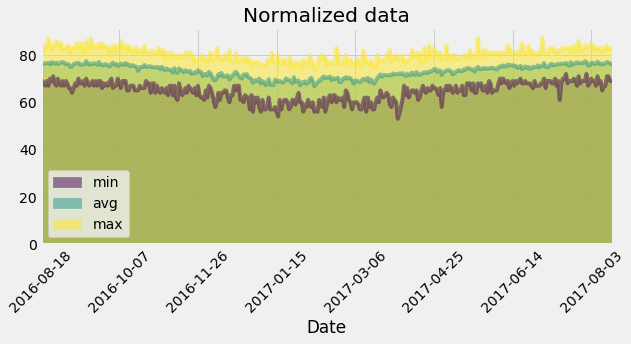

In [163]:
# Plot the daily normals as an area plot with `stacked=False`
normals_df.plot(kind='area', stacked=False, alpha=0.5, colormap='viridis',
        title='Normalized data',figsize=(9,5))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()